- Created by Tias Guns <Tias.Guns@kuleuven.be>, first part based on:

## Handwritten Digit Recognition
- Author = Amitrajit Bose
- Dataset = MNIST
- [Medium Article Link](https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- Frameworks = PyTorch

The first 3 boxes are identical to the p0 notebook; then it starts...

### Necessary Imports

Recommended installation instructions:
https://pytorch.org/get-started/locally

This typically involves installing python3, python3-numpy, python3-matplotlib through an installer (anaconda) or system manager (apt), then installing torch and torchvision from python through conda or pip.

In [ ]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

### Download The Dataset & Define The Transforms

It is best to do this before the practical; + it allows you to test whether your setup works!

It will download the files into the __same directory as where you stored this notebook__.

It will take a minute or two. It will only download it once, so you can rerun this cell over and over.

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data (effect: all values between -1 and 1)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('.', download=True, train=True, transform=transform)
testset = datasets.MNIST('.', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
print("Data loaded.")

### Showing a grid

In [ ]:
def show_grid_img(images):
    dim = 9
    figure = plt.figure()
    num_of_images = dim*dim
    for index in range(num_of_images):
        plt.subplot(dim, dim, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_grid_img(images)

### Defining The Neural Network

We will now define the __architecture__ of the neural network.

We define two architectures: a standard multi-layer perceptron network (the classical MLP) and a famous vision-specific architecture which is known to do well on MNIST: the LeNet architecture.

Building an architecture is done _declaratively_ in pytorch, very elegant as you will see.

### MLP architecture:
(this is the standard fully connected used-since-the-80's network)

The number of layers and its size are rather arbitrarily chosen.

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [ ]:
from torch import nn

# Build a feed-forward network, declaratively
def MLP():
    return nn.Sequential(nn.Flatten(), # Flatten MNIST images into a 784 long vector
                         nn.Linear(28*28, 120),
                         nn.ReLU(),
                         nn.Linear(120, 84), # the image shows the case of (128, 64), see LeNet below for why I changed it
                         nn.ReLU(),
                         nn.Linear(84, 10),
                         nn.LogSoftmax(dim=1))
print(MLP())

### LeNet architecture

We now built a LeNet architecture, introduced by Yann LeCun in 1998. It consists of a convolutional layer followed by max-pooling, again a convolutional layer followed by max pooling, and then two fully connected layer followed by the LogSoftMax() output layer.


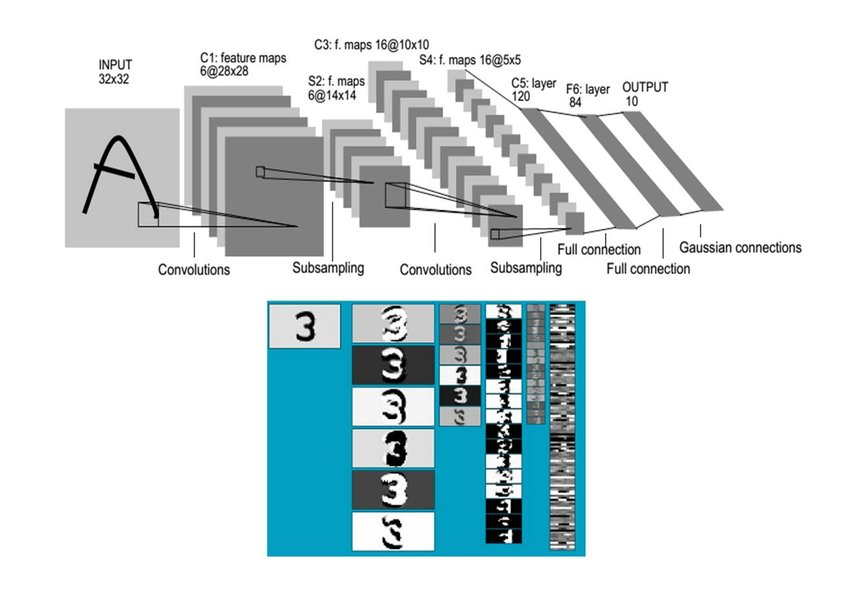

The image above shows a graphical representation of the network, and for a an example input what the output of each layer could be.

_Good to know:_ the convolutions are copied a number of times, each copy creates its own 'channel' (you can think of it as an extra dimension) hence the multiple versions. The weights, which are modified during training, are implicit in each layer in this syntax.


In [ ]:
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, calibrated=False):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

print(LeNet())

### Core Training Of Neural Network

Training is through stochastic gradient descent, with a given learning rate (lr) and momentum. Together with the number of epochs, the number of passes over the data, these determine the _hyperparameters_.

In [ ]:
from torch import optim

def train_model(model, optimizer, epochs):
    # the stochastic gradient descent loop
    criterion = nn.NLLLoss() # negative log likelihood as loss
    time0 = time()
    print("Training starts, using", len(trainset), "training instances...")
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
    
            # Training pass
            optimizer.zero_grad()
        
            output = model(images)
            loss = criterion(output, labels)
        
            #This is where the model learns by backpropagating
            loss.backward()
        
            #And optimizes its weights here
            optimizer.step()
        
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    # model is now trained


# hyperparameters
model = MLP()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 1

train_model(model, optimizer, epochs)

## Visualising the output

We use a helper function and then show both the input image, its output probability distribution and the maximum likelihood prediction.

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap='gray_r');
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

def show_one_prediction(images, labels, i=0):
    # Turn off gradients to speed up this part
    img = images[i].unsqueeze(1) # classifier optimized for batches, make it a batch of 1
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    view_classify(img, ps)
    print("Predicted Digit =", probab.index(max(probab)), "\tActual =",int(labels[i]))

images, labels = next(iter(testloader))
show_one_prediction(images, labels)

You may notice a wrong prediction and varying class probabilities. That's because the network has _high training error_, measured by the training loss.

__Task for you__: Adjust the hyperparameters (and your patience) to train a better model!

In [ ]:
# you can use this box to train alternative model(s) with other hyperparameters and inspect the result


### Model Evaluation

Manually and visually inspecting a few predictions is good practice, but to know how good your model is you need a proper evaluation.

The _loss_ computes the negative loglikelihood of the predicted _probabilities_. The code below computes the _accuracy_ of the actualy predicted class (not its probability):

In [ ]:
def eval_model(model, testloader):
    # returns (all_count, correct_count, all_loss)
    correct_count, all_count = 0, 0
    avgloss = 0.0
    
    criterion = nn.NLLLoss() # negative log likelihood as loss
    with torch.no_grad(): # Turn off gradients to speed up this part
        for images,labels in testloader:
            logprobs = model(images)
            avgloss += criterion(logprobs, labels)
            preds = torch.argmax(logprobs, dim=1)
            correct_count += int(torch.sum(preds == labels))
            all_count += len(labels)
    return (all_count, correct_count, avgloss/len(testloader))

(all_count, correct_count, avgloss) = eval_model(model, testloader)
print("Number Of Images Tested =", all_count)
print("\tAvg test loss =", float(avgloss))
print("\tTest accuracy =", (correct_count/all_count)*100,"%")

In [ ]:
# another box for you to play with hyperparameters / evaluation

## Visual sudoku time!

We will use your trained classifier to predict the output of a 'visual sudoku'. You will then use those predictions to solve the sudoku.

For __solving the sudoku's__, I recommend:
  * If you participated in the hackathon, use MiniCP
  * If you know how to model CP problems, use the python interface to _ortools_ (conda install ortools) https://developers.google.com/optimization/install/python
 
We use a sudoku instance from the following link:
http://hakank.org/minizinc/sudoku_problems2/index.html

In [ ]:
# sudoku's, from http://hakank.org/minizinc/sudoku_problems2/index.html

sudoku_p0 = torch.IntTensor([[0,0,0, 2,0,5, 0,0,0],
                             [0,9,0, 0,0,0, 7,3,0],
                             [0,0,2, 0,0,9, 0,6,0],
                             [2,0,0, 0,0,0, 4,0,9],
                             [0,0,0, 0,7,0, 0,0,0],
                             [6,0,9, 0,0,0, 0,0,1],
                             [0,8,0, 4,0,0, 1,0,0],
                             [0,6,3, 0,0,0, 0,8,0],
                             [0,0,0, 6,0,8, 0,0,0]])
sudoku_p0

In [ ]:
# sample a dataset index with that value/label
def sample_by_label(labels, value):
    # primitive but it works...
    idxs = torch.randperm(len(labels))
    for idx in idxs:
        if labels[idx] == value:
            return idx
# sample a dataset index for each non-zero number
def sample_visual_sudoku(sudoku_p, loader):
    for (images, labels) in loader: # sample one batch
        nonzero = sudoku_p > 0
        vizsudoku = torch.zeros((9,9,1,28,28), dtype=images.dtype)
        idxs = torch.LongTensor([sample_by_label(labels, value) for value in sudoku_p[nonzero]])
        vizsudoku[nonzero] = images[idxs]
        return vizsudoku
    
vizsudoku = sample_visual_sudoku(sudoku_p0, testloader)
show_grid_img(vizsudoku.reshape(-1,28,28)) # list of 81 images

With the data prepared, we can now make the predictions!

In [ ]:
def predict_sudoku(model, vizsudoku):
    nonzero = (vizsudoku.reshape([-1,28,28]).sum(dim=(1,2)) != 0).reshape(9,9)
    predsudoku = torch.zeros((9,9), dtype=torch.long)
    with torch.no_grad():
        images = vizsudoku[nonzero]
        logprobs = model(images)
        preds = torch.argmax(logprobs, dim=1)
        predsudoku[nonzero] = preds
    return predsudoku

preds = predict_sudoku(model, vizsudoku)
preds

Let's see if we made errors...

In [ ]:
def vizsudoku_errors(sudoku_p, preds):
    has_error = (sudoku_p != preds)
    return (torch.sum(has_error), sudoku_p*has_error, preds*has_error)

(cnt, e_real, e_pred) = vizsudoku_errors(sudoku_p0, preds)
print("Nr errors:", int(cnt), " out of ", int(torch.sum(sudoku_p0 > 0)))
print("Labels that were wrongly predicted:")
e_real

## Solving time

__Task: up to you to compute the sudoku solution given the predictions!__

You can use any solver you wish...

For convenience, you may want to write the output to CSV:

In [ ]:
import csv

with open("preds.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    # preds.tolist() gives a plain list of lists of integers
    csvWriter.writerows( preds.tolist() )

Or experiment with ortools: https://developers.google.com/optimization/cp/queens

In [ ]:
from ortools.sat.python import cp_model

csp = cp_model.CpModel()
x = csp.NewIntVar(1, 3, 'x') # x in {1,2,3}
csp.Add(x > 1)
csp.Add(x != 2)

solver = cp_model.CpSolver()
status = solver.Solve(csp)
    
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("X =",solver.Value(x))
else:
    print("CSP infeasible")

# Saving classifier

You might want to save your classifier for later, by running the following line: 

In [ ]:
torch.save(model.state_dict(), "myNet")